**Validation of the runs in /Data Diversity Reproduction/**

*This file should eventually be replaced by a .py file.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from model import GPT2
import utils as u
from collect_data import LinRegData
from predictions import Ridge, oracle, DiscreteMMSE, zero
from tqdm import tqdm
import yaml

# torch.set_float32_matmul_precision('highest')

assert torch.cuda.is_available()
device = 'cuda'

with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

/home/jovyan/mop4/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
step = 500000
run_ids = [
    "m5zm5bz9",
    "2dpt2ynr",
    "zya8efq4",
    "2fen9r0m",
    "agbondwy",
    "4ls1ca4j",
    "8f3tqgrw",
    "xxalxzep",
    "ertyo8do"
]

In [3]:
runs = {
    run_id: {
        "ckpt_path": f"/home/jovyan/data-diversity-reproduction/Data Diversity Reproduction/{run_id}/checkpoints/epoch=0-step={step}.ckpt",
        "task_pool_path": f"/home/jovyan/data-diversity-reproduction/Data Diversity Reproduction/{run_id}/task_pool.pt"
    } for run_id in run_ids
}

In [4]:
# # Validation for longer training runs
# run_ids.append("7d07ktcg")
# runs["7d07ktcg"] = {
#     "ckpt_path": f"/home/jovyan/data-diversity-reproduction/Data Diversity Reproduction/7d07ktcg/checkpoints/epoch=0-step=2000000.ckpt",
#     "task_pool_path": f"/home/jovyan/data-diversity-reproduction/Data Diversity Reproduction/7d07ktcg/task_pool.pt"
# }

# run_ids.append("f7d9y6hm")
# runs["f7d9y6hm"] = {
#     "ckpt_path": f"/home/jovyan/data-diversity-reproduction/Data Diversity Reproduction/f7d9y6hm/checkpoints/epoch=0-step=2000000.ckpt",
#     "task_pool_path": f"/home/jovyan/data-diversity-reproduction/Data Diversity Reproduction/f7d9y6hm/task_pool.pt"
# }

# # Validation for old training runs
# Incorrect weight decay, incorrect lr schedule
# step = 524288
# run_ids = [
#     # "lhuztt7a",
#     "0nk3a4b3",
#     "javn7bsd",
#     "ycr0ep5j",
#     "58es818e",
#     "79tldc2i",
#     "95tkac8y",
#     "hdsybk5p",
#     "iycztm7r",
# ]
# runs = {
#     run_id: {
#         "ckpt_path": f"/home/jovyan/data-diversity-reproduction/Data Diversity Reproduction/{run_id}/checkpoints/epoch=0-step={step}.ckpt",
#         "task_pool_path": f"/home/jovyan/data-diversity-reproduction/outputs/{run_id}_task_pool.pt"
#     } for run_id in run_ids
# }

# # Correct weight decay, incorrect lr schedule
# step = 524288
# run_ids = [
#     "wupv4stc",
#     "nqccstbh"
# ]

In [5]:
for run_id, run in runs.items():
    task_pool = torch.load(run["task_pool_path"])
    run["task_pool_size"] = task_pool.shape[0]

run_ids = sorted(run_ids, key=lambda x: runs[x]["task_pool_size"])
task_pool_size = np.array([runs[run_id]["task_pool_size"] for run_id in run_ids])

In [6]:
model_names = ["Ridge", "DiscreteMMSE", "MOP", "Oracle"]

for run_id, run in runs.items():
    task_pool = torch.load(run["task_pool_path"])

    models = {
        "Ridge": Ridge(config['noise_scale']),
        "DiscreteMMSE": DiscreteMMSE(task_pool, config['noise_scale']),
        "MOP": GPT2.load_from_checkpoint(run["ckpt_path"], n_dims_in=config['dim']+1, n_positions=config['n_points'], config=config).eval().to(device),
        "Oracle": oracle,
        # "Zero": zero
    }

    with torch.no_grad():
        linregdata = LinRegData(config, task_pool=task_pool)
        data_iterator = linregdata.batch_generator(config['n_validation_batches'])
        predictions = {k: [] for k in models}
        for i, batch in enumerate(data_iterator):
            for k, v in batch.items():
                batch[k] = v.to(device)
            for model_name, model in models.items():
                predictions[model_name].append(model(batch))
        for model_name in models:
            predictions[model_name] = torch.cat(predictions[model_name]).cpu()
        run["preds_pt"] = predictions

for run_id, run in runs.items():
    task_pool = torch.load(run["task_pool_path"])

    models = {
        "Ridge": Ridge(config['noise_scale']),
        "DiscreteMMSE": DiscreteMMSE(task_pool, config['noise_scale']),
        "MOP": GPT2.load_from_checkpoint(run["ckpt_path"], n_dims_in=config['dim']+1, n_positions=config['n_points'], config=config).eval().to(device),
        "Oracle": oracle,
        # "Zero": zero
    }

    with torch.no_grad():
        linregdata = LinRegData(config, no_pool=True)
        data_iterator = linregdata.batch_generator(config['n_validation_batches'])
        predictions = {k: [] for k in models}
        for i, batch in enumerate(data_iterator):
            for k, v in batch.items():
                batch[k] = v.to(device)
            for model_name, model in models.items():
                predictions[model_name].append(model(batch))
        for model_name in models:
            predictions[model_name] = torch.cat(predictions[model_name]).cpu()
        run["preds_true"] = predictions

In [76]:
first_idx = 15
idx_len = 1
idx = np.arange(first_idx, first_idx + idx_len)

for run in runs.values():
    for i in range(len(model_names)):
        for j in range(i+1,len(model_names)):
            mi = model_names[i]
            mj = model_names[j]
            for pred_type in ("preds_pt", "preds_true"):
                sqerrd = ((run[pred_type][mi][:,idx] - run[pred_type][mj][:,idx])**2).numpy() / config['dim']
                msed = np.mean(sqerrd, axis=-1) if len(sqerrd.shape) == 2 else sqerrd
                run[('mse/d',pred_type,mi,mj)] = np.mean(msed)
                run[('err_bar',pred_type,mi,mj)] = np.std(msed) * (3/np.sqrt(msed.size))

                run[('mse/d',pred_type,mj,mi)] = run[('mse/d',pred_type,mi,mj)]
                run[('err_bar',pred_type,mj,mi)] = run[('err_bar',pred_type,mi,mj)]

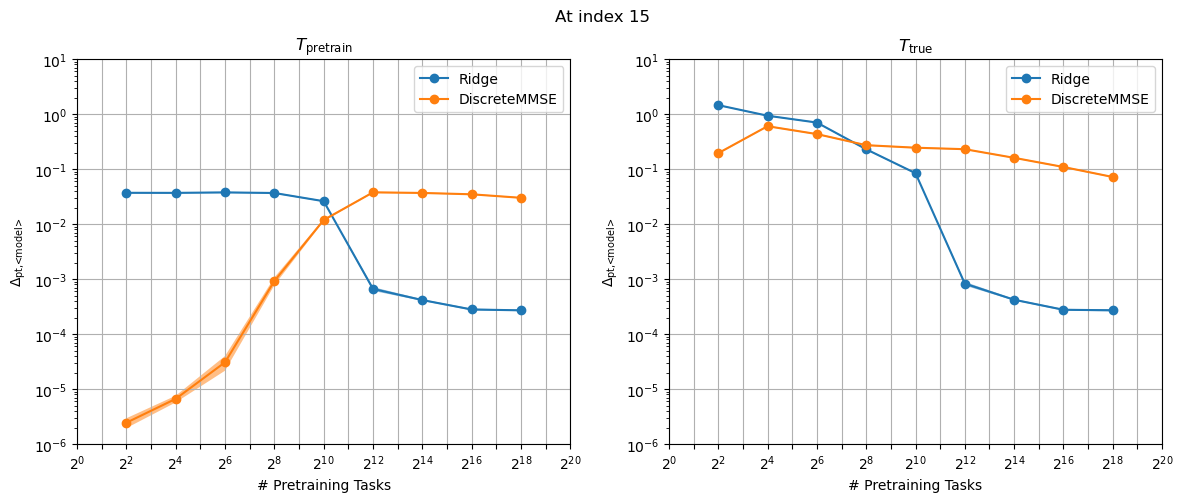

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

for j, dist in enumerate(('preds_pt', 'preds_true')):
    for predictor in ('Ridge', 'DiscreteMMSE'):
        means = np.array([runs[run_id][('mse/d', dist, 'MOP', predictor)] for run_id in run_ids])
        err_bar = np.array([runs[run_id][('err_bar', dist, 'MOP', predictor)] for run_id in run_ids])
        ax[j].loglog(
            task_pool_size,
            means,
            marker='o',
            label=predictor
        )
        ax[j].fill_between(
            task_pool_size,
            means - err_bar,
            means + err_bar,
            alpha=0.5
        )

ax[0].set_title("$T_\\text{pretrain}$")
ax[1].set_title("$T_\\text{true}$")

for axis in ax:
    x_range = list(range(0,21))
    x = [2**x for x in x_range]
    axis.set_xticks(x, labels=[(f"$2^{{{x}}}$" if not x%2 else "") for x in x_range])
    axis.tick_params(axis='x', which='minor', bottom=False)
    axis.set_ylim([1e-6,10])
    axis.set_xlabel("# Pretraining Tasks")
    axis.set_ylabel("$\Delta_{\\text{pt,<model>}}$")
    axis.grid()
    axis.legend()

idx_str = str(first_idx) if idx_len == 1 else f"{first_idx} to {first_idx+idx_len-1}"
fig.suptitle(f"At index {idx_str}")
fig.show()


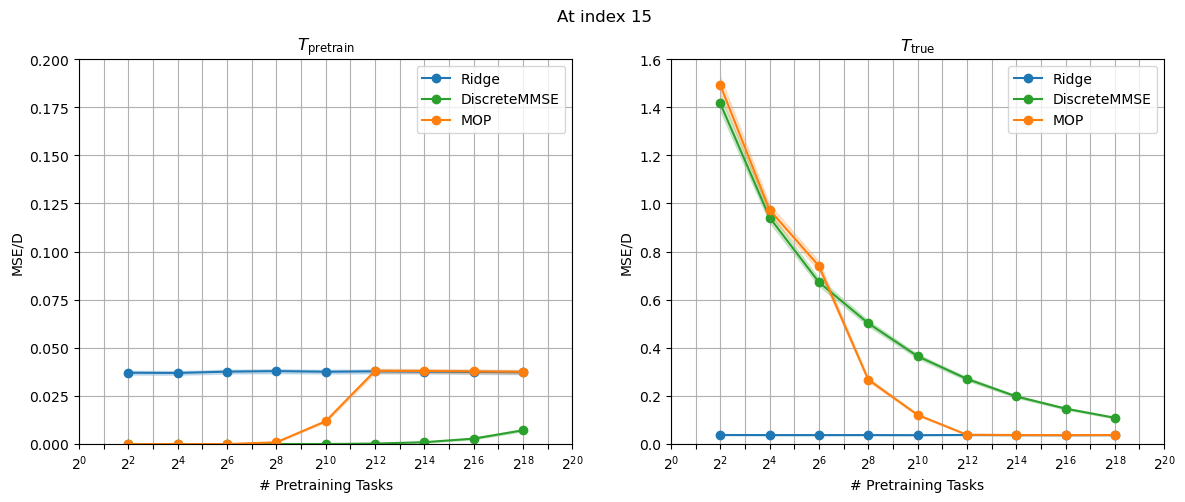

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
colors = ['1f77b4', '2ca02c', 'ff7f0e', 'd62728', '9467bd', '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']

for j, dist in enumerate(('preds_pt', 'preds_true')):
    for i, model_name in enumerate(('Ridge', 'DiscreteMMSE', 'MOP')):
        means = np.array([runs[run_id][('mse/d', dist, 'Oracle', model_name)] for run_id in run_ids])
        err_bar = np.array([runs[run_id][('err_bar', dist, 'Oracle', model_name)] for run_id in run_ids])
        ax[j].semilogx(task_pool_size, means, label=model_name, marker='o', color="#"+colors[i])
        ax[j].fill_between(task_pool_size, means - err_bar, means + err_bar, alpha=0.2, color="#"+colors[i])


ax[0].set_title("$T_\\text{pretrain}$")
ax[0].set_ylim([0,0.2])

ax[1].set_title("$T_\\text{true}$")
ax[1].set_ylim([0,1.6])

for axis in ax:
    x_range = list(range(0,21))
    x = [2**x for x in x_range]
    axis.set_xticks(x, labels=[(f"$2^{{{x}}}$" if not x%2 else "") for x in x_range])
    axis.tick_params(axis='x', which='minor', bottom=False)
    axis.set_xlabel("# Pretraining Tasks")
    axis.set_ylabel("MSE/D")
    axis.grid()
    axis.legend(loc='upper right')

idx_str = str(first_idx) if idx_len == 1 else f"{first_idx} to {first_idx+idx_len-1}"
fig.suptitle(f"At index {idx_str}")
fig.show()

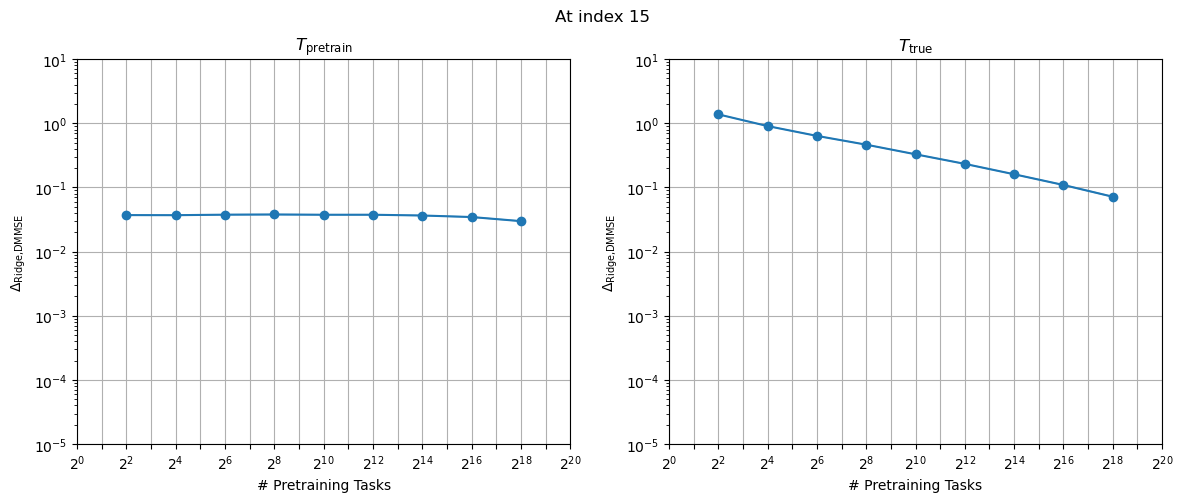

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
for j, dist in enumerate(('preds_pt', 'preds_true')):
    means = np.array([runs[run_id][('mse/d', dist, 'DiscreteMMSE', 'Ridge')] for run_id in run_ids])
    err_bar = np.array([runs[run_id][('err_bar', dist, 'DiscreteMMSE', 'Ridge')] for run_id in run_ids])
    ax[j].loglog(task_pool_size, means, marker='o')
    ax[j].fill_between(task_pool_size, means - err_bar, means + err_bar, alpha=0.5)

ax[0].set_title("$T_\\text{pretrain}$")
ax[1].set_title("$T_\\text{true}$")

for axis in ax:
    x_range = list(range(0,21))
    x = [2**x for x in x_range]
    axis.set_xticks(x, labels=[(f"$2^{{{x}}}$" if not x%2 else "") for x in x_range])
    axis.tick_params(axis='x', which='minor', bottom=False)
    axis.set_ylim([1e-5,10])
    axis.set_xlabel("# Pretraining Tasks")
    axis.set_ylabel("$\Delta_\\text{Ridge,DMMSE}$")
    axis.grid()

idx_str = str(first_idx) if idx_len == 1 else f"{first_idx} to {first_idx+idx_len-1}"
fig.suptitle(f"At index {idx_str}")
fig.show()